In [1]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn tqdm sentencepiece protobuf optuna -q

# Cell 2: Import Libraries and Load Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_cosine_with_hard_restarts_schedule_with_warmup
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SST5 dataset
ds = load_dataset("SetFit/sst5")
train_data = ds["train"]
val_data = ds["validation"]
test_data = ds["test"]

# Cell 3: Tokenization
deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def tokenize_data(data, tokenizer, max_length=128):
    return data.map(
        lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=max_length), 
        batched=True
    )

train_data_deberta = tokenize_data(train_data, deberta_tokenizer)
val_data_deberta = tokenize_data(val_data, deberta_tokenizer)

def convert_to_torch(data, batch_size=32):
    data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return DataLoader(data, batch_size=batch_size, shuffle=True, pin_memory=True)

train_loader_deberta = convert_to_torch(train_data_deberta)
val_loader_deberta = convert_to_torch(val_data_deberta)

#Custom Model with Dropout Regularization
class DebertaV3WithDropout(nn.Module):
    def __init__(self, pretrained_model_name, num_labels, dropout_prob=0.2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            pretrained_model_name, num_labels=num_labels
        )
        self.dropout = nn.Dropout(dropout_prob)
        hidden_size = self.model.config.hidden_size
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        # New classification head with batch norm
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size // 2, num_labels)
        )
        self.model.classifier = self.classifier

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = self.dropout(outputs.logits)
        return {"loss": outputs.loss, "logits": logits} if labels is not None else {"logits": logits}

# Cell 5: Training and Evaluation Functions
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    return get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=num_warmup_steps, 
        num_training_steps=num_training_steps
    )

def compute_regularization_loss(model, l1_lambda, l2_lambda):
    l1_reg = 0.0
    l2_reg = 0.0
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    for name, param in model.named_parameters():
        if 'bias' not in name and 'LayerNorm' not in name:
            l1_reg += torch.sum(torch.abs(param))
            l2_reg += torch.sum(param.pow(2)) / 2
    
    return (l1_lambda * l1_reg + l2_lambda * l2_reg) / num_params

def evaluate_model(model, data_loader, device="cuda", show_cm=True):
    model.eval()
    true_labels, pred_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            preds = torch.argmax(outputs["logits"], dim=-1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average="weighted")
    
    if show_cm:
        cm = confusion_matrix(true_labels, pred_labels)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.show()
    
    return accuracy, f1

# Cell 6: Training Final Model
def train_final_model(model, train_loader, val_loader, device, num_epochs=50, 
                      learning_rate=1e-6, l1_lambda=5e-6, l2_lambda=1e-6):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_scheduler(
        optimizer, 
        num_warmup_steps=100, 
        num_training_steps=len(train_loader) * num_epochs
    )
    
    model.to(device)
    training_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            inputs = {key: val.to(device) for key, val in batch.items() if key != "label"}
            labels = batch["label"].to(device)
            
            outputs = model(**inputs, labels=labels)
            loss = outputs["loss"] + compute_regularization_loss(model, l1_lambda, l2_lambda)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_losses.append(loss.item())
        
        # Calculate train loss
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        training_losses.append(avg_epoch_loss)
        
        # Validate
        model.eval()
        total_val_loss, true_labels, pred_labels = 0, [], []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val.to(device) for key, val in batch.items() if key != "label"}
                labels = batch["label"].to(device)
                
                outputs = model(**inputs, labels=labels)
                loss = outputs["loss"]
                total_val_loss += loss.item()
                
                preds = torch.argmax(outputs["logits"], dim=-1)
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(preds.cpu().numpy())
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_accuracy, val_f1 = evaluate_model(model, val_loader, device, show_cm=False)
        
        print(f"Epoch {epoch + 1}: Loss = {avg_epoch_loss:.4f}, "
              f"Val_loss = {avg_val_loss:.4f}, "
              f"Val F1 = {val_f1:.4f}, "
              f"Val_accuracy = {val_accuracy:.4f}")
    
    return training_losses, val_losses



README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

In [2]:
# Cell 7: Run Training
# Initialize model
final_model = DebertaV3WithDropout("microsoft/deberta-v3-base", num_labels=5)

# Train the model for 50 epochs
training_losses, val_losses = train_final_model(
    final_model, 
    train_loader_deberta, 
    val_loader_deberta, 
    device,
    num_epochs=20
)

# Evaluate final model


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/267 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 267/267 [02:19<00:00,  1.91it/s]


Epoch 1: Loss = 1.6676, Val_loss = 1.5860, Val F1 = 0.1361, Val_accuracy = 0.2679


Epoch 2: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 2: Loss = 1.6317, Val_loss = 1.4648, Val F1 = 0.3474, Val_accuracy = 0.4514


Epoch 3: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 3: Loss = 1.3878, Val_loss = 1.2447, Val F1 = 0.3769, Val_accuracy = 0.4714


Epoch 4: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 4: Loss = 1.2359, Val_loss = 1.1905, Val F1 = 0.3790, Val_accuracy = 0.4614


Epoch 5: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 5: Loss = 1.1700, Val_loss = 1.1519, Val F1 = 0.4275, Val_accuracy = 0.4914


Epoch 6: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 6: Loss = 1.1240, Val_loss = 1.1472, Val F1 = 0.4220, Val_accuracy = 0.4841


Epoch 7: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 7: Loss = 1.0912, Val_loss = 1.1132, Val F1 = 0.4670, Val_accuracy = 0.5123


Epoch 8: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 8: Loss = 1.0553, Val_loss = 1.1199, Val F1 = 0.4978, Val_accuracy = 0.5159


Epoch 9: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 9: Loss = 1.0440, Val_loss = 1.1053, Val F1 = 0.5093, Val_accuracy = 0.5232


Epoch 10: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 10: Loss = 1.0185, Val_loss = 1.1324, Val F1 = 0.5014, Val_accuracy = 0.5141


Epoch 11: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 11: Loss = 1.0091, Val_loss = 1.1205, Val F1 = 0.5083, Val_accuracy = 0.5177


Epoch 12: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 12: Loss = 0.9954, Val_loss = 1.1127, Val F1 = 0.5095, Val_accuracy = 0.5195


Epoch 13: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 13: Loss = 0.9834, Val_loss = 1.0953, Val F1 = 0.5173, Val_accuracy = 0.5268


Epoch 14: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 14: Loss = 0.9803, Val_loss = 1.1021, Val F1 = 0.5127, Val_accuracy = 0.5223


Epoch 15: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 15: Loss = 0.9834, Val_loss = 1.1194, Val F1 = 0.5139, Val_accuracy = 0.5232


Epoch 16: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 16: Loss = 0.9665, Val_loss = 1.1126, Val F1 = 0.5113, Val_accuracy = 0.5213


Epoch 17: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 17: Loss = 0.9712, Val_loss = 1.1074, Val F1 = 0.5116, Val_accuracy = 0.5213


Epoch 18: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 18: Loss = 0.9634, Val_loss = 1.1204, Val F1 = 0.5176, Val_accuracy = 0.5268


Epoch 19: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 19: Loss = 0.9702, Val_loss = 1.1082, Val F1 = 0.5107, Val_accuracy = 0.5204


Epoch 20: 100%|██████████| 267/267 [02:18<00:00,  1.92it/s]


Epoch 20: Loss = 0.9699, Val_loss = 1.1179, Val F1 = 0.5157, Val_accuracy = 0.5259


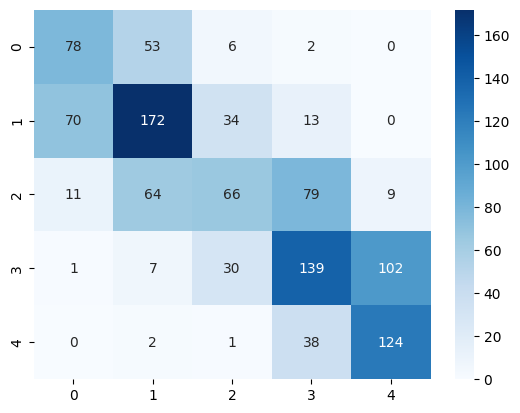

Final Validation Accuracy: 0.5259
Final Validation F1 Score: 0.5157


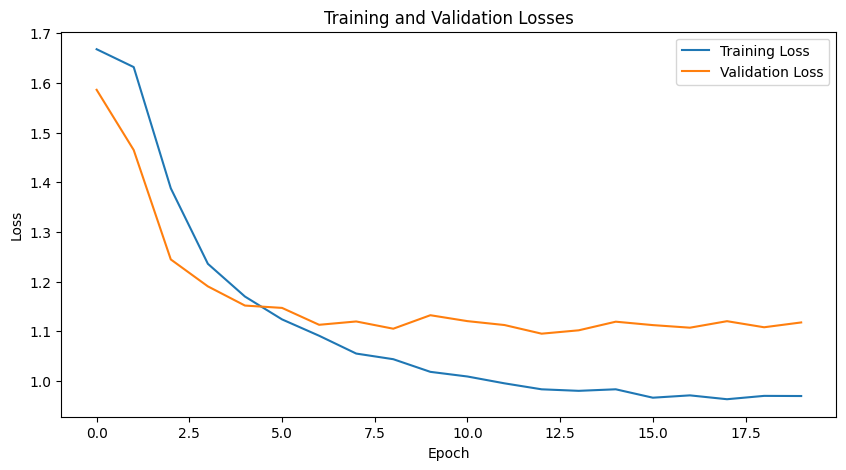

In [3]:
final_accuracy, final_f1 = evaluate_model(final_model, val_loader_deberta, device)
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"Final Validation F1 Score: {final_f1:.4f}")

# Optional: Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()